### test para comprobar la inversión DIF + tiempo

In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha
import fibonacci_sphere
import xyzfield
import bspline

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

In [2]:
import igrf
importlib.reload(igrf)

<module 'igrf' from '/home/josecper/Programs/python/igrf.py'>

en primer lugar cargamos los coeficientes del IGRF para el intervalo 1900-2015

In [3]:
times, (l, m), gcoefs = igrf.load("../data/IGRF/igrf12coeffs.txt")

primera comprobación: generamos una malla regular en todo el globo sobre la que evaluamos el campo en uno de los knot points del IGRF, y comprobamos que sale una cosa razonable

In [4]:
thetav, phiv = fibonacci_sphere.grid(n=4000)

In [5]:
phiv.shape

(4000,)

In [6]:
Bx, By, Bz = scha.xyzfield(l, m, l, gcoefs[5], thetav, phiv)

<IPython.core.display.Javascript object>


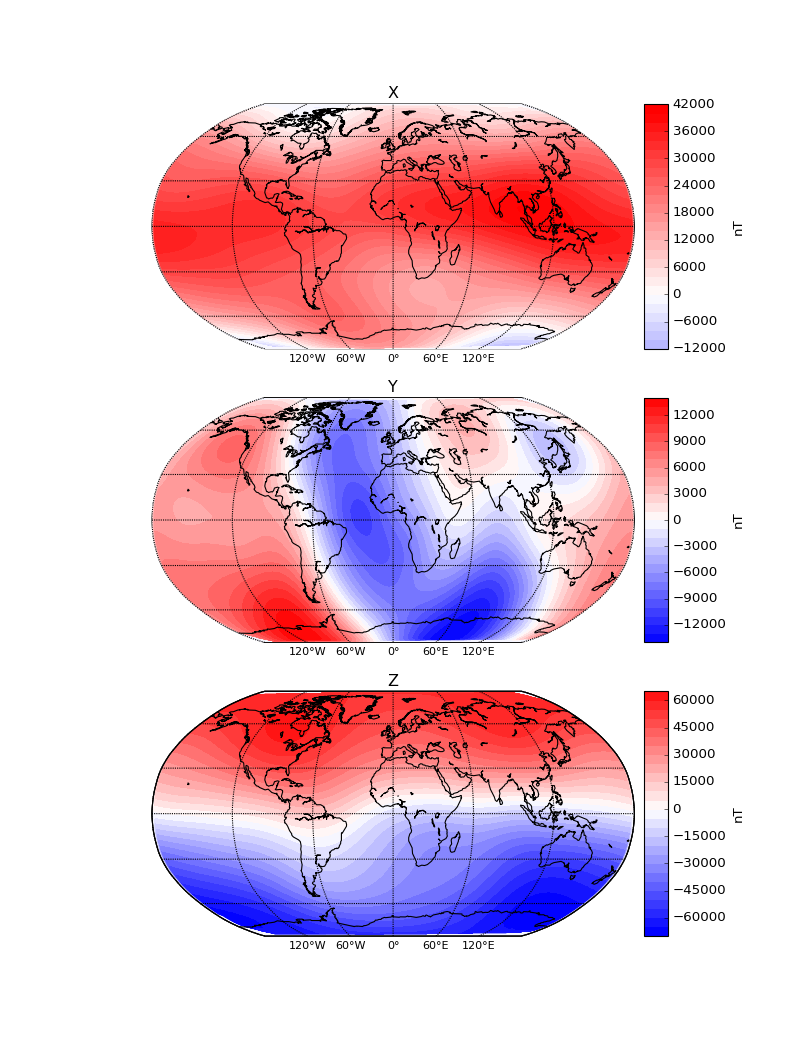

/usr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


<IPython.core.display.Javascript object>


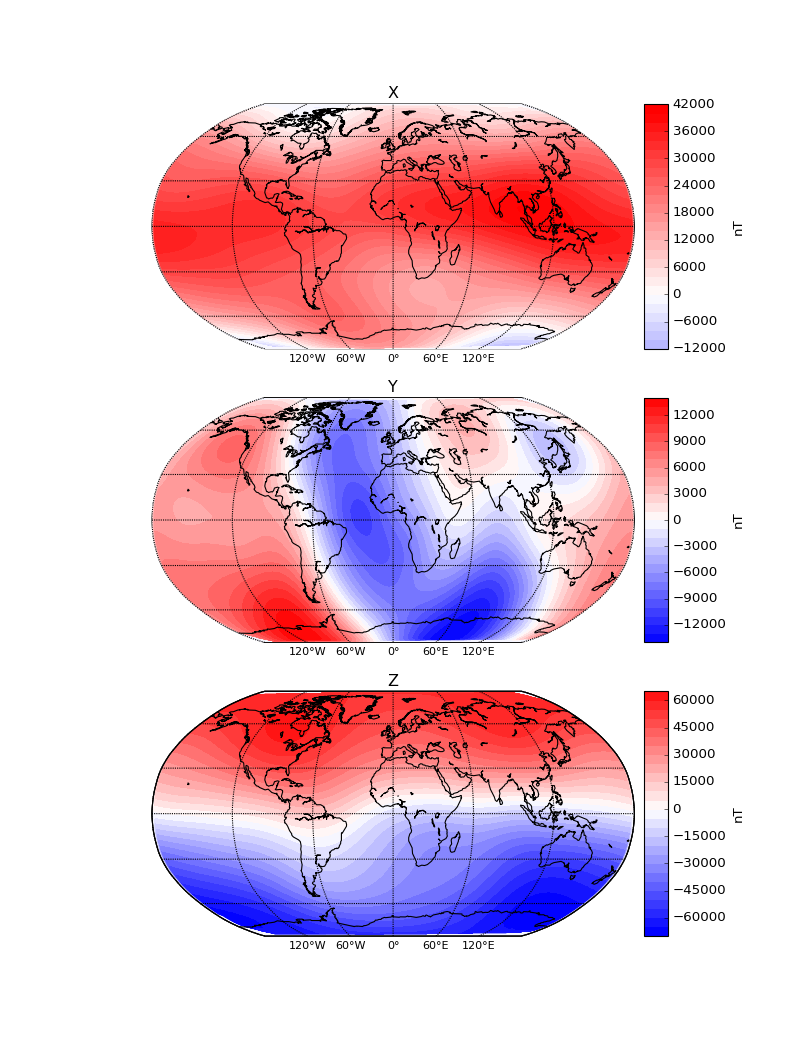

In [7]:
xyzfield.xyzcontour(thetav, phiv, Bx, By, Bz, regular=False)

todo ok

#### generación de datos en todo el intervalo
ahora, generamos un gran número de datos por todo el intervalo temporal del IGRF, identificando los coeficientes de dicho modelo con los correspondientes a una base de armónicos esféricos y splines centrados en los knot points del propio modelo.

In [8]:
data_amount = 50000

t_rand = numpy.random.rand(data_amount)*(times[-1]-times[0]) + times[0]
theta_rand = numpy.random.rand(data_amount)*numpy.pi
phi_rand = numpy.random.rand(data_amount)*numpy.pi*2

gp = numpy.concatenate(gcoefs, axis=0)

Bx_rand, By_rand, Bz_rand = scha.xyzfieldt(l, m, l, times, gcoefs, theta_rand, phi_rand, t_rand)
D_rand, I_rand, F_rand, H_rand = xyzfield.xyz2difh(Bx_rand, By_rand, Bz_rand)

casi seguro que esto está bien hecho

<IPython.core.display.Javascript object>


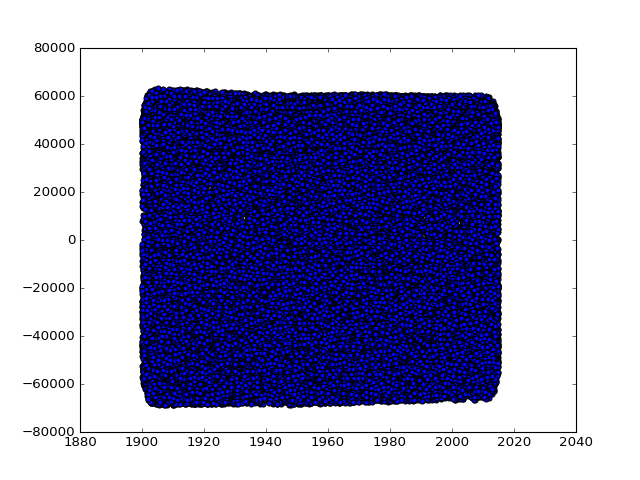

In [9]:
fig, ax = pyplot.subplots()

ax.scatter(t_rand, Bz_rand)

(aquí podemos ver una gran mole de datos)

#### test de modelización
ahora modelamos el campo utilizando el algoritmo del scha con los polinomios de legendre de grado entero (es decir, k = l = n, o un casquete equivalente a todo el globo), a partir de los datos sintetizados en la sección anterior.

In [10]:
deg_max = 4
l2 = l[:deg_max*(deg_max+2)]; m2 = m[:deg_max*(deg_max+2)]

In [11]:
g0 = numpy.zeros((len(times), len(l2))); g0[:, 0] = -30000
gp_inv = scha.invert_dift(theta_rand, phi_rand, t_rand, D_rand, I_rand, F_rand, (l2, m2, l2), times,
                          steps=20, g0=g0, reg_coef_time=0, theta_0 = 2)

[####################]  iteration 20  : rms = 0.028644895127

comprobamos que todo es estupendo comparando el resultado con los coeficientes del IGRF

<IPython.core.display.Javascript object>


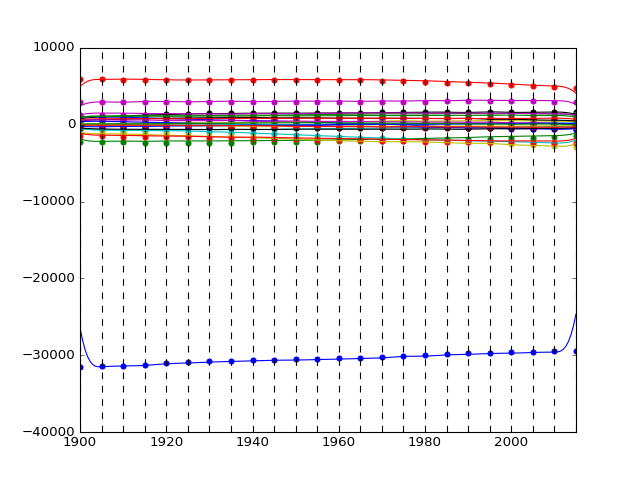

In [12]:
tt = numpy.linspace(1900, 2015, 200)
big=bspline.condition_array(times, tt) @ gp_inv

fig, ax = pyplot.subplots()

for knot, gc, g_igrf in zip(times, big.T, gcoefs.T):
    ax.plot([knot, knot], [-40000, 10000], "k--")
    line = ax.plot(tt, gc)
    ax.scatter(times, g_igrf, color=line[0].get_color())

ax.set_ybound(-40000, 10000)
ax.set_xbound(1900, 2015)

# cool and nice

#### ahora modelemos regionalmente

de los 50000 datos generados elegiremos los que caigan en el gran casquete europeo de la felicidad y los transformaremos adecuadamente (los generamos de nuevo en un margen de lat/lon que permiten que caigan casi todos dentro del casquete)

In [13]:
import trig

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 50.0))
lat_c, lon_c = 90 - numpy.rad2deg(theta_c), numpy.rad2deg(phi_c)

#los generamos para que caigan muchos en la zona 

data_amount = 50000

t_rand = numpy.random.rand(data_amount)*(times[-1]-times[0]) + times[0]
theta_rand = numpy.random.rand(data_amount)*2*theta_0d+theta_c-theta_0d
phi_rand = numpy.random.rand(data_amount)*2*theta_0d+phi_c-theta_0d

gp = numpy.concatenate(gcoefs, axis=0)

Bx_rand, By_rand, Bz_rand = scha.xyzfieldt(l, m, l, times, gcoefs, theta_rand, phi_rand, t_rand)
D_rand, I_rand, F_rand, H_rand = xyzfield.xyz2difh(Bx_rand, By_rand, Bz_rand)

in_circle = trig.angulardist(theta_rand, phi_rand, theta_c, phi_c) < theta_0d

theta_reg, phi_reg, t_reg, D_reg, I_reg, F_reg = numpy.vstack((theta_rand, phi_rand, t_rand,
                                                               D_rand, I_rand, F_rand))[:, in_circle]

del t_rand, theta_rand, phi_rand, Bx_rand, By_rand, Bz_rand, D_rand, I_rand, F_rand, H_rand

rotación mágica

In [14]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_reg_r, phi_reg_r = scha.rotate_coords(1.0, theta_reg, phi_reg, rot_mat)

D_reg_r = scha.rotate_declination(D_reg, theta_c, phi_c, theta_reg, phi_reg, theta_reg_r)

veamos los datos en un plot

<IPython.core.display.Javascript object>


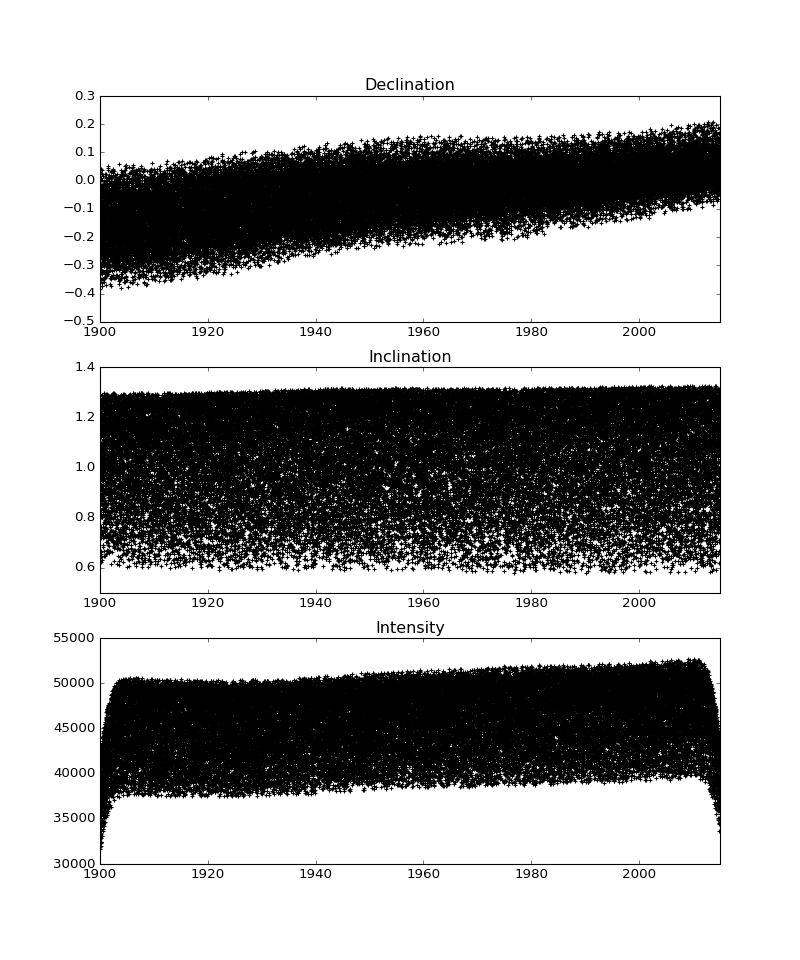

In [15]:
fig, axes = pyplot.subplots(3, 1, figsize=(10, 12))

for ax, field, title in zip(axes, (D_reg, I_reg, F_reg), ("Declination", "Inclination", "Intensity")):
    ax.scatter(t_reg, field, marker="+", color="black")
    ax.set_xbound(1900, 2015)
    ax.set_title(title)

#### modelización de la muerte

primero hallamos las raíces correspondientes al casquete guay

In [20]:
kmax = 4; m_range = numpy.arange(0, kmax+1)
k_reg, m_reg, n_reg = scha.join_roots(scha.degree(m_range, theta_0, kmax))
knots = times

In [22]:
gp_reg = scha.invert_dift(theta_reg_r, phi_reg_r, t_reg, D_reg_r, I_reg, F_reg, (k_reg, m_reg, n_reg), times, steps=25)

[####################]  iteration 25  : rms = 0.000680128982092

In [23]:
Bx_inv_reg, By_inv_reg, Bz_inv_reg = scha.xyzfieldt(k_reg, m_reg, n_reg, times, gp_reg,
                                                    theta_reg_r, phi_reg_r, t_reg)
D_inv_reg, I_inv_reg, F_inv_reg, H_inv_reg = xyzfield.xyz2difh(Bx_inv_reg, By_inv_reg, Bz_inv_reg)
D_inv_reg_rr = scha.rotate_declination(D_inv_reg, theta_c, phi_c, theta_reg, phi_reg, theta_reg_r, invert=True)
D_inv_reg_rr = trig.center_angles(D_inv_reg_rr)

<IPython.core.display.Javascript object>


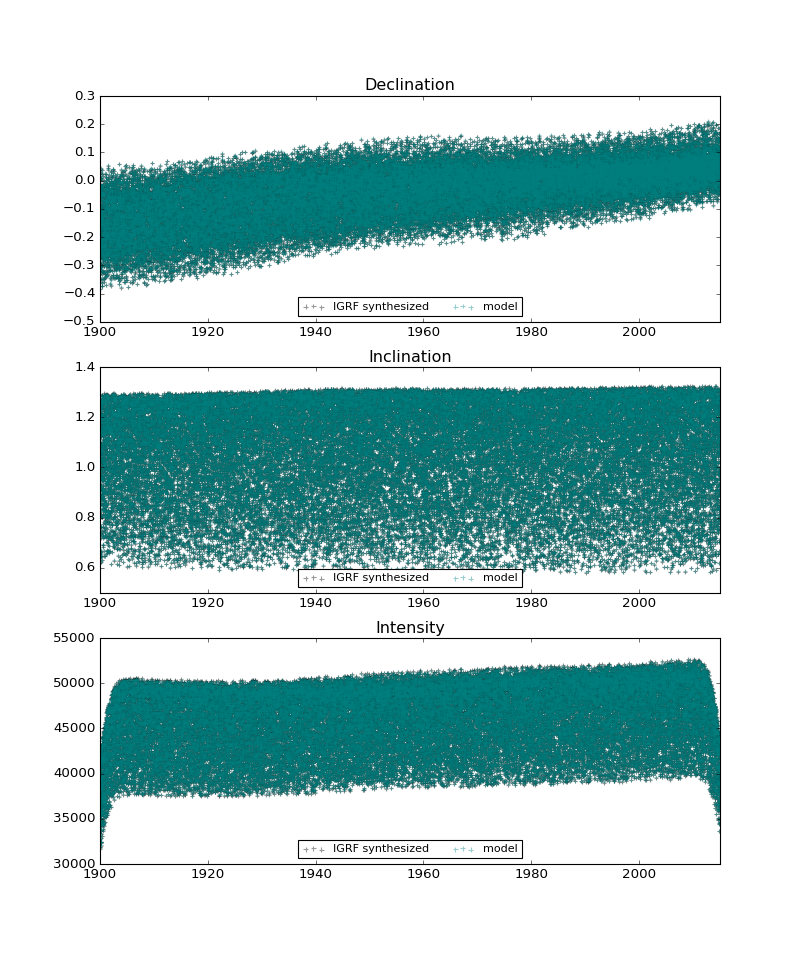

In [24]:
fig, axes = pyplot.subplots(3, 1, figsize=(10, 12))

for ax, field, field_inv, title in zip(axes, (D_reg, I_reg, F_reg), (D_inv_reg_rr, I_inv_reg, F_inv_reg),
                                       ("Declination", "Inclination", "Intensity")):
    ax.scatter(t_reg, field, marker="+", color="black", label="IGRF synthesized", alpha=0.4)
    ax.scatter(t_reg, field_inv, marker="+", color="teal", label="model", alpha=0.4)
    ax.legend(loc="lower center", ncol=2, fontsize="small")
    ax.set_xbound(1900, 2015)
    ax.set_title(title)

- hmmmm
- vease que hacen falta mazo de iteraciones

#### residuos

In [25]:
D_res, I_res, F_res = (D_inv_reg_rr - D_reg, I_inv_reg - I_reg, F_inv_reg - F_reg)

<IPython.core.display.Javascript object>


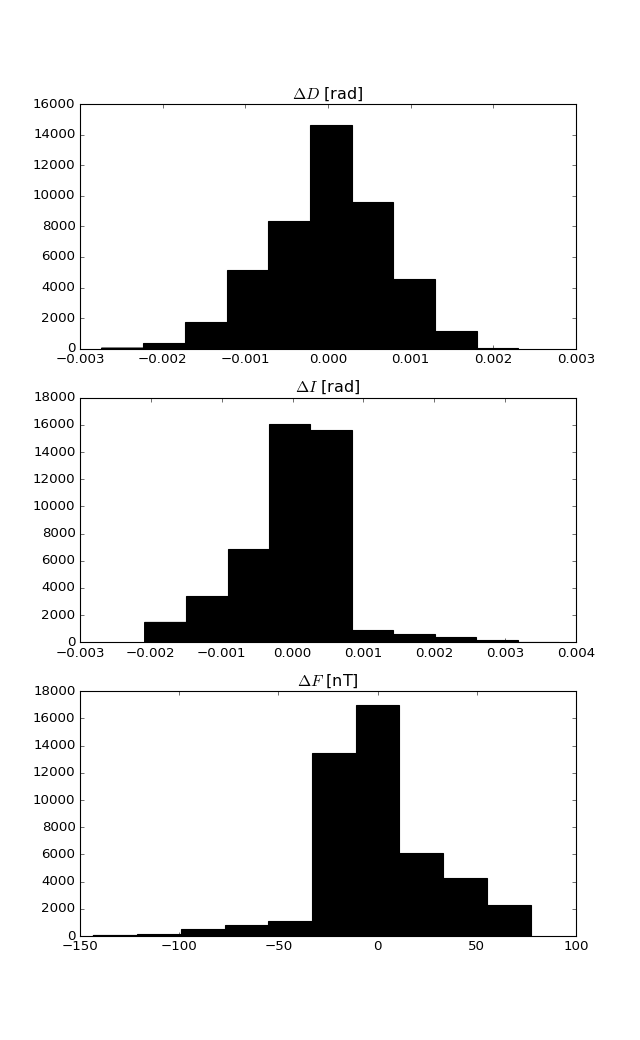

In [26]:
fig, axes = pyplot.subplots(3, 1, figsize = (8, 13))

for ax, field, title in zip(axes, (D_res, I_res, F_res),
                            ("$\Delta D$ [rad]", "$\Delta I$ [rad]", "$\Delta F$ [nT]")):
    ax.hist(field, color="black")
    ax.set_title(title)

los residuos son razonablemente pequeños parece ser

### utilicemos los datos con distribución espacial realista

In [27]:
datos_realistas = numpy.loadtxt("../data/IGRF/archeo_volc_database_3k_IGRF_2015.0.dat",
                                usecols = (0, 2, 3, 10, 11, 12))
datos_realistas[datos_realistas == 999] = numpy.nan
#datos_realistas = datos_realistas[~numpy.any(numpy.isnan(datos_realistas[:, 0:3]))]

In [28]:
t_re, lat_re, lon_re, Bx_re, By_re, Bz_re = datos_realistas.T
D_re, I_re, F_re, H_re = xyzfield.xyz2difh(Bx_re, By_re, Bz_re)

In [29]:
theta_re, phi_re = numpy.deg2rad((90 - lat_re, lon_re))

#### global

In [72]:
deg_max = 8
l2 = l[:deg_max*(deg_max+2)]; m2 = m[:deg_max*(deg_max+2)]

In [42]:
times_re = numpy.linspace(-1200, 2000, 24)

In [73]:
g0 = numpy.zeros((len(times_re), len(l2))); g0[:, 0] = -30000
gp_inv_re = scha.invert_dift(theta_re, phi_re, t_re, D_re, I_re, F_re, (l2, m2, l2), times_re,
                          steps=26, g0=g0, reg_coef_spatial=0.1, reg_coef_time=1.0, theta_0 = numpy.pi-0.01)

[####################]  iteration 26  : rms = 0.0200004919378

<IPython.core.display.Javascript object>


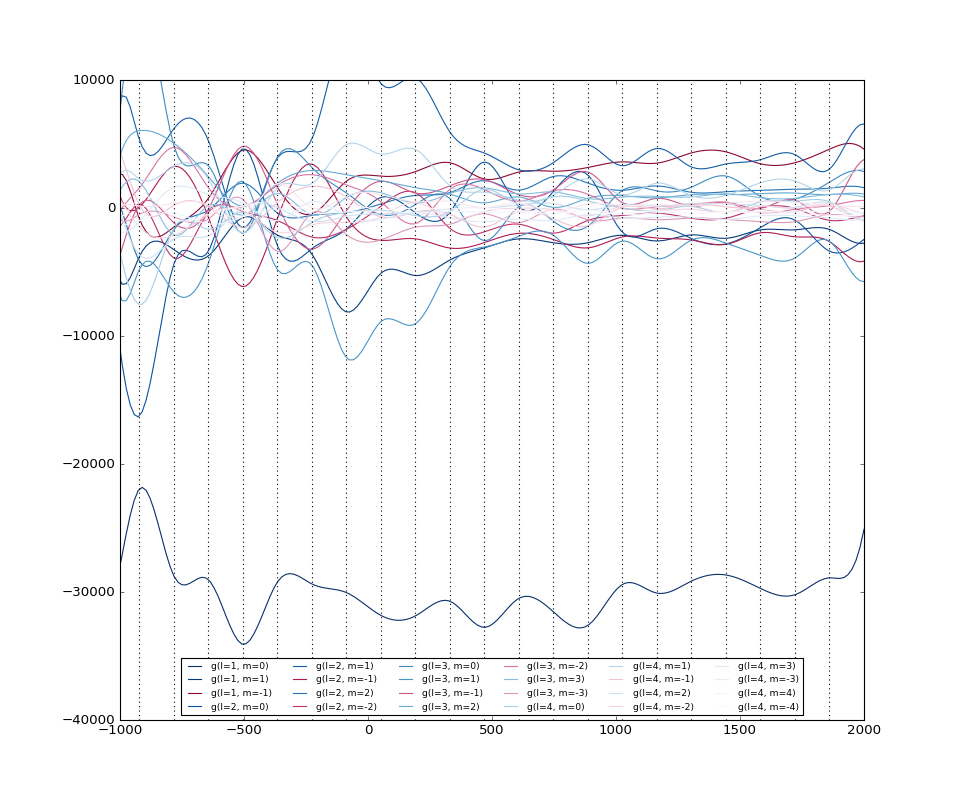

In [70]:
tt = numpy.linspace(-1200, 2000, 200)
big=bspline.condition_array(times_re, tt) @ gp_inv_re

gradient = pyplot.cm.Blues_r(numpy.linspace(0, 1, big.shape[1]))
gradient[m2 < 0, :3] = matplotlib.colors.hsv_to_rgb(matplotlib.colors.rgb_to_hsv(gradient[m2 < 0, :3])+\
                                                   numpy.array((0.36, 0.0, 0.0)) % 1.0)


fig, ax = pyplot.subplots(figsize=(12, 10))

for gc, color, ll, mm in zip(big.T, gradient, l2, m2):
    line = ax.plot(tt, gc, color=color, label="g(l={:d}, m={:d})".format(int(ll), int(mm)))
    
for knot in times_re:
    ax.plot([knot, knot], [-40000, 10000], "k:")
    #ax.scatter(times, g_igrf, color=line[0].get_color())

ax.legend(loc='lower center', ncol=6, fontsize='x-small')
    
ax.set_ybound(-40000, 10000)
ax.set_xbound(-1000, 2000)

#### momento dipolar

In [67]:
dm = 1e-9*6731.2e3**3*1e7*numpy.sqrt((big[:, :3]**2).sum(axis=1))

<IPython.core.display.Javascript object>


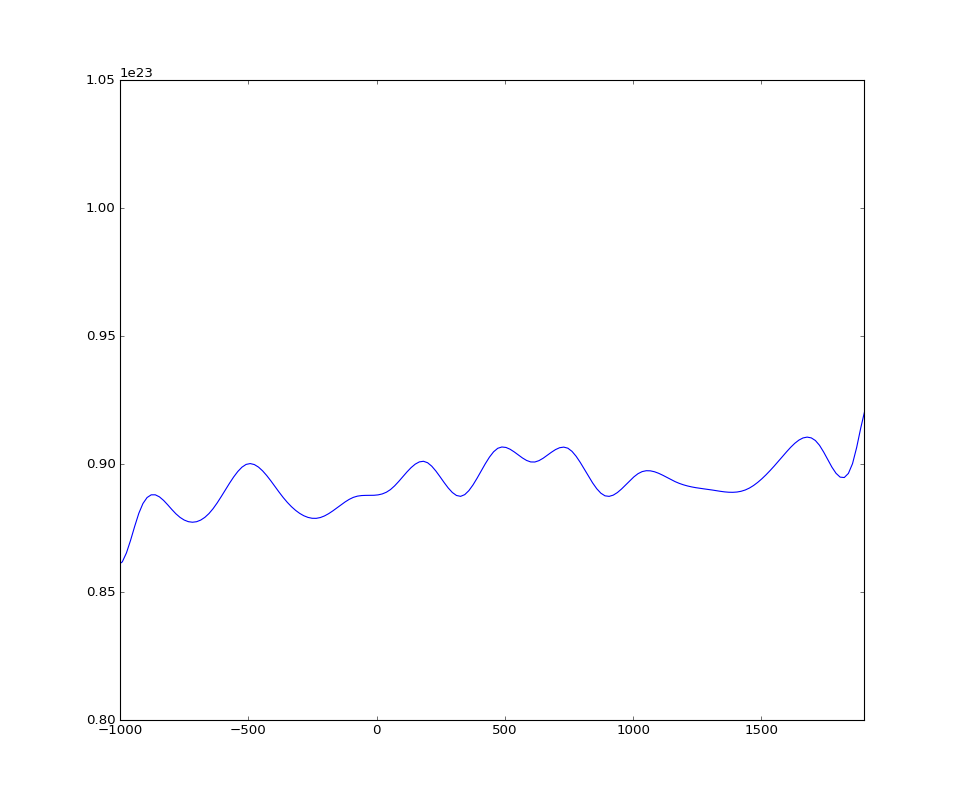

In [68]:
fig, ax = pyplot.subplots(figsize=(12, 10))

ax.plot(tt, dm)
ax.set_xbound(-1000, 1900)